# Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

<b>Оператор предоставляет два основных типа услуг:</b> 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

<b>Также доступны такие услуги:</b>

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

<b>Файл contract_new.csv</b> 

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

<b>Файл personal_new.csv</b>

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

<b>Файл internet_new.csv</b>

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

<b>Файл phone_new.csv</b>

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

# Загрузка данных и первичный анализ

In [1]:
!pip install phik
!pip install scikit-learn -U

     |████████████████████████████████| 677 kB 949 kB/s eta 0:00:01
     |████████████████████████████████| 13.5 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 90.7 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from scipy.stats import mannwhitneyu
from sklearn.dummy import DummyClassifier

In [3]:
contract_new = pd.read_csv('/datasets/contract_new.csv')
personal_new = pd.read_csv('/datasets/personal_new.csv')
internet_new = pd.read_csv('/datasets/internet_new.csv')
phone_new = pd.read_csv('/datasets/phone_new.csv')

In [4]:
display(contract_new.head())
display(contract_new.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

In [5]:
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'], errors='coerce')

In [6]:
display(personal_new.head())
display(personal_new.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

In [7]:
display(internet_new.head())
display(internet_new.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

In [8]:
display(phone_new.head())
display(phone_new.info())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [9]:
def check_duplicates(df, name):
    dup_count = df.duplicated().sum()
    print(f"В {name}: {dup_count} дубликатов")
    if dup_count > 0:
        print(df[df.duplicated()].head())
    print('-' * 50)
    
def process_df(df, name):
    # Пропуски
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(f"\n Пропуски {name}:")
    display(missing)
    check_duplicates(df, name)
    df = df.drop_duplicates().reset_index(drop=True)
    
    return df

In [10]:
contract_new = process_df(contract_new, "contract_new")
personal_new = process_df(personal_new, "personal_new")
internet_new = process_df(internet_new, "internet_new")
phone_new = process_df(phone_new, "phone_new")


 Пропуски contract_new:


TotalCharges    11
dtype: int64

В contract_new: 0 дубликатов
--------------------------------------------------

 Пропуски personal_new:


Series([], dtype: int64)

В personal_new: 0 дубликатов
--------------------------------------------------

 Пропуски internet_new:


Series([], dtype: int64)

В internet_new: 0 дубликатов
--------------------------------------------------

 Пропуски phone_new:


Series([], dtype: int64)

В phone_new: 0 дубликатов
--------------------------------------------------


In [11]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0)

<b>Вывод по первичному анализу данных</b>
- Первичный анализ показал что все данные в правильном формате, кроме столбца TotalCharges (общие расходы абонента) файла contract_new, столбец был переведен в числовой формат с двойной точностью.

- Также обнаружено что столбец TotalCharges имеет 11 пропусков, возможно клиенты еще не оплатили счет на момент предоставления данных т.е это новые клиенты. Решено заполнить пропуски значением 0.

# Исследовательский анализ данных

In [12]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], errors='coerce')
display(contract_new['BeginDate'].dtype)
contract_new['BeginDate'].isna().sum()

dtype('<M8[ns]')

0

In [13]:
contract_new['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

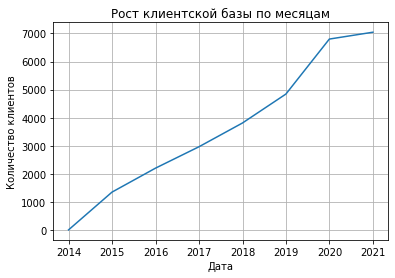

In [14]:
clients_by_month = (
    contract_new
    .set_index('BeginDate')
    .resample('Y')
    .size()
)
clients_cumsum = clients_by_month.cumsum()

plt.figure()
plt.plot(clients_cumsum)
plt.xlabel('Дата')
plt.ylabel('Количество клиентов')
plt.title('Рост клиентской базы по месяцам')
plt.grid(True)
plt.show()

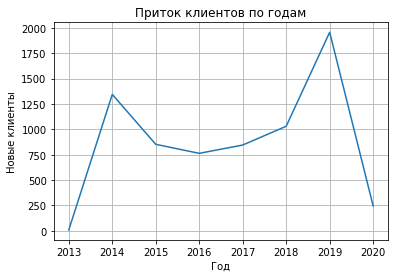

In [15]:
clients_by_year = contract_new['BeginDate'].dt.year.value_counts().sort_index()
plt.figure()
plt.plot(clients_by_year)
plt.xlabel('Год')
plt.ylabel('Новые клиенты')
plt.title('Приток клиентов по годам')
plt.grid(True)
plt.show()

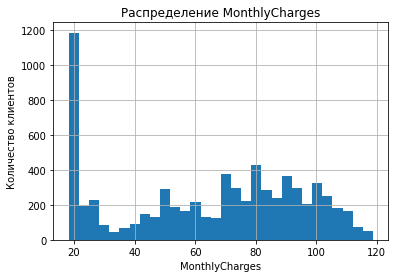

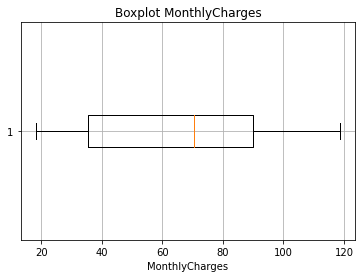

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [16]:
plt.figure()
plt.hist(contract_new['MonthlyCharges'].dropna(), bins=30)
plt.xlabel('MonthlyCharges')
plt.ylabel('Количество клиентов')
plt.title('Распределение MonthlyCharges')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(contract_new['MonthlyCharges'].dropna(), vert=False)
plt.xlabel('MonthlyCharges')
plt.title('Boxplot MonthlyCharges')
plt.grid(True)
plt.show()

contract_new['MonthlyCharges'].describe()

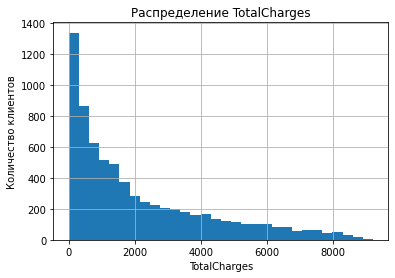

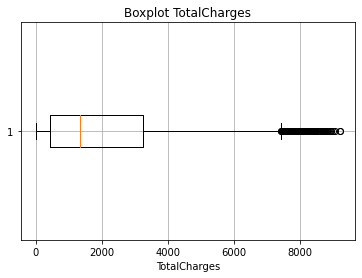

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

In [17]:
plt.figure()
plt.hist(contract_new['TotalCharges'].dropna(), bins=30)
plt.xlabel('TotalCharges')
plt.ylabel('Количество клиентов')
plt.title('Распределение TotalCharges')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(contract_new['TotalCharges'].dropna(), vert=False)
plt.xlabel('TotalCharges')
plt.title('Boxplot TotalCharges')
plt.grid(True)
plt.show()

contract_new['TotalCharges'].describe()

In [18]:
contract_new['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

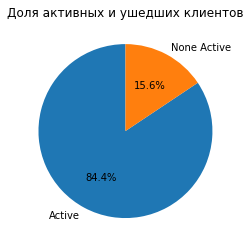

In [19]:
data = [
    contract_new['EndDate'].isna().sum() + (contract_new['EndDate'] == 'No').sum(),  # активные
    contract_new['EndDate'].ne('No').sum() - (contract_new['EndDate'].isna().sum())  # ушедшие
]

labels = ['Active', 'None Active']

plt.figure()
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Доля активных и ушедших клиентов')
plt.show()

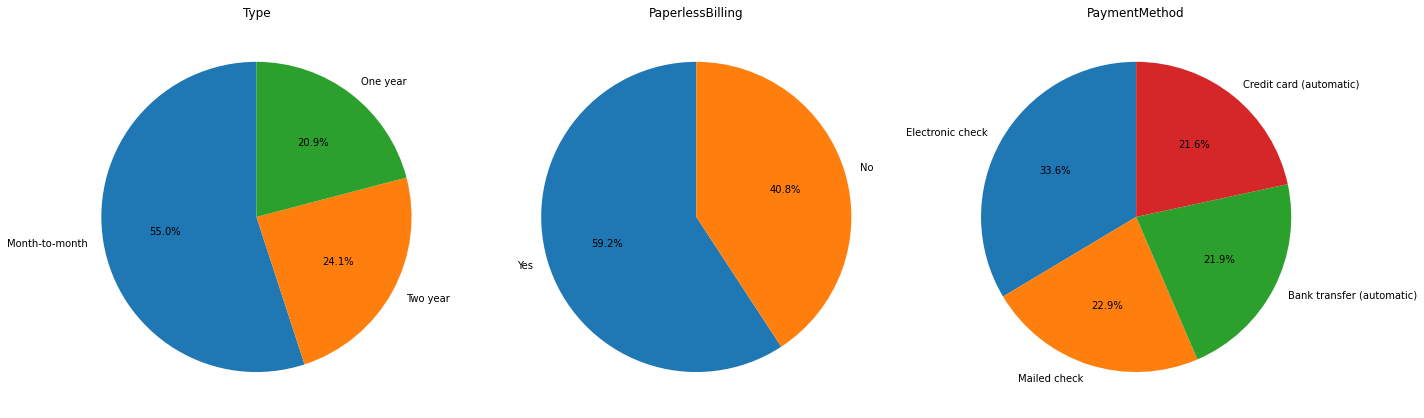

In [20]:
cols = ['Type', 'PaperlessBilling', 'PaymentMethod']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 строка, 3 графика

for ax, col in zip(axes, cols):
    data = contract_new[col].value_counts()
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col)

plt.tight_layout()
plt.show()

<b>Вывод</b>

- Данные были представлены с 2013 по 2020 год
- Исследовательский анализ файла <b>contract_new</b> показал что количество клиентов растет, были года когда приток новых клиентов снижался, но в целом динамика положительная.
- Много клиентов платят 20 долларов в месяц за услуги, но есть большое количество клиентов которые платят в месяц больше. Медиана находится на уровне 65 долларов. Наличие сильного разброса по ежемесячной оплате говорит о том что клиенты не органичиваются только одним видом услуг и покупают доп опции.
- В среднем клиент принес компании 2115 долларов, но из за большого разброса медиана находится в районе 1343 долларов.
- Около 15.6% клиентов решили не продлевать контракты (имеется дата окончания договора). Остальные 84.4% продолжают оставаться клиентами компании.
- Клиенты предпочитают оплачивать счет в основном помесячно 55%, доля тех кто оплачивает раз в год 20.9% и 24.1% тех кто оплачивает 1 раз в два года.
- Большинство клиентов 59.2% предпочитают электронную счет-фактуру, остальные продолжают работать с бумажными документами.
- По методам оплаты, нет явного лидера. все способы оплаты используются одинаково.

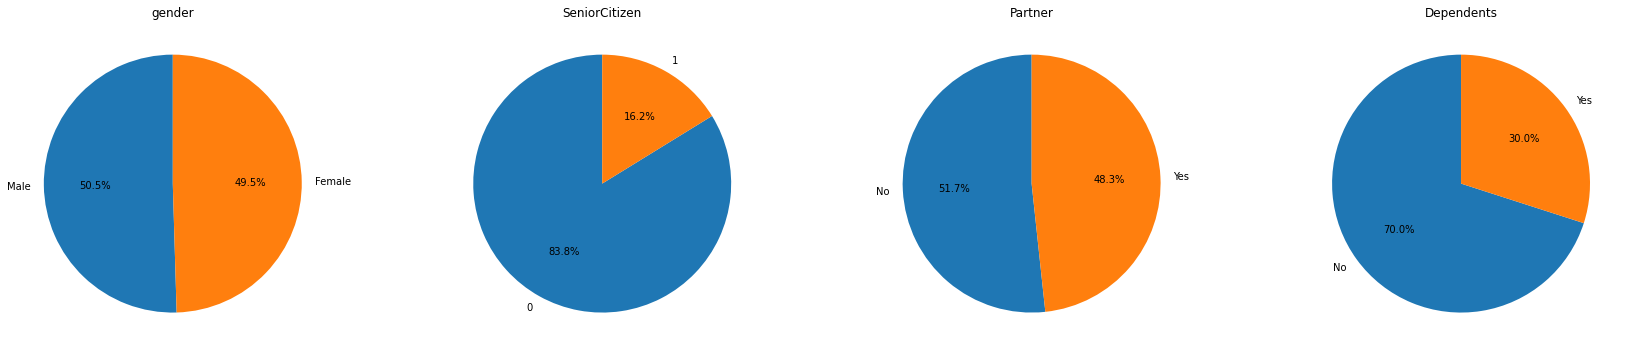

In [21]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for ax, col in zip(axes, cols):
    data = personal_new[col].value_counts()
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col)

plt.tight_layout()
plt.show()

<b>Вывод</b>

Файл <b>personal_new</b> содержит в основном бинарные признаки клиентов

- Доля клиентов разного пола примерно одинаково.
- Большинство клиентов не являются персионерами 83.78%.
- В доля клиентов в браке примерно одинаковое.
- Около 70% клиентов не имеют детей, что говорит о том что абонентами являются молодеж.

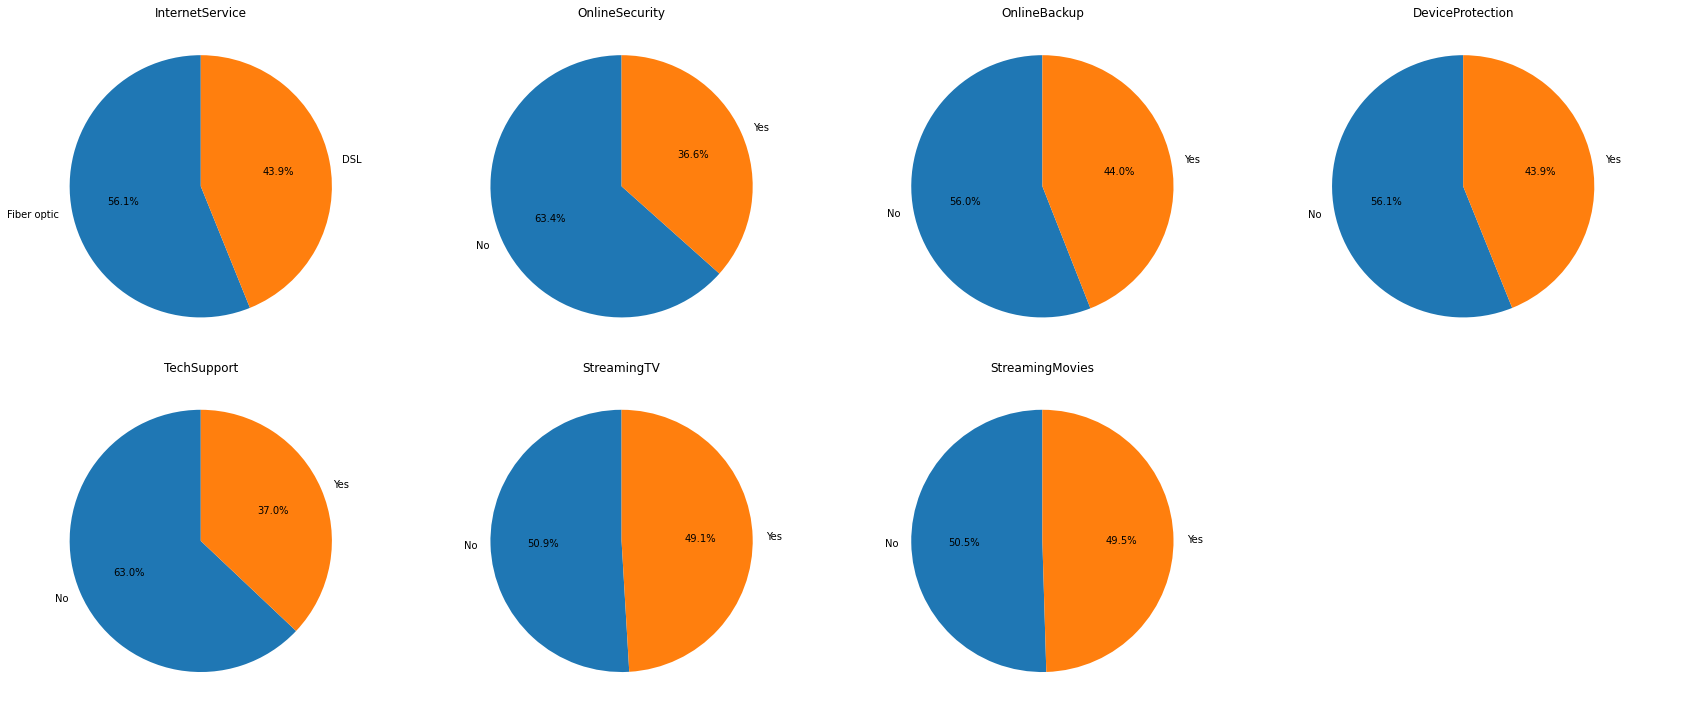

In [22]:
cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    data = internet_new[col].value_counts()
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(col)

for j in range(len(cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


<b>Вывод</b>

Файл <b>internet_new</b> состоит в основном из бинарных признаков, 

- Все бинарные признаки связаны и технической частью (тип подключения, блокировщик опасных сайтов, доп подключение телевидени и прочее). Не по одному признаку не было явного доминирования какого либо признака.

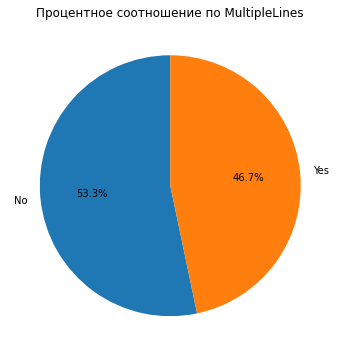

In [23]:
data = phone_new['MultipleLines'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
plt.title('Процентное соотношение по MultipleLines')
plt.show()

<b>Вывод</b>

Файл <b>phone_new</b> состоит из одного бинарного признака. 

- MultipleLines - подключение телефона к нескольким линиям одновременно. Явного доминирования одного признака не обнаружено.

# Вывод по исследовательскому анализу данных

- Была получена важная информация по динамике роста клиентов, и годам когда рост числа новых клиентов снижалась.
- Визуализирована распределение ежемесячной оплаты поступающая от клиентов, самым популярным значением является 20 долларов.
- Выявлено сколько в среднем клиент принес компании средств (2115 долларов).
- Установлено что около 15.6% за период с 2013 по 2020 год решили не продлевать контракты.
- Клиентами копании являются в основном молодые граждане (как мужчины так и женщины) без детей (70%), возможно в браке с вероятность на 48.3%.
- Целевой признак EndDate не сбалансирован, это надо учесть при делении данных на обучающиую и тестовую выборку.

# Объединение данных и генерация новых признаков

In [24]:
contract_new.shape

(7043, 8)

In [25]:
full_data_set = contract_new.merge(personal_new, on='customerID', how='left') \
                 .merge(internet_new, on='customerID', how='left') \
                 .merge(phone_new, on='customerID', how='left')
full_data_set.shape

(7043, 20)

In [26]:
display(full_data_set.head())
display(full_data_set.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

None

In [27]:
full_data_set.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [28]:
full_data_set['InternetService'] = full_data_set['InternetService'].fillna('No internet')

internet_dependent_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in internet_dependent_cols:
    full_data_set[col] = full_data_set[col].fillna('No internet')

full_data_set['MultipleLines'] = full_data_set['MultipleLines'].fillna('No phone service')

full_data_set.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

<b>Вывод</b>
- Была проведена операция по объединению файла по столбцу id.


- Пропуски не случайные, а логические:

InternetService и все интернет-опции имеют 5517 значит 1526 клиентов не имеют интернет-услуги поставим значение <b>No internet</b>.

MultipleLines — телефонная услуга, у части клиентов её нет, отсюда 682 пропуска, поставим значение <b>No phone service</b>.

<Figure size 864x720 with 0 Axes>

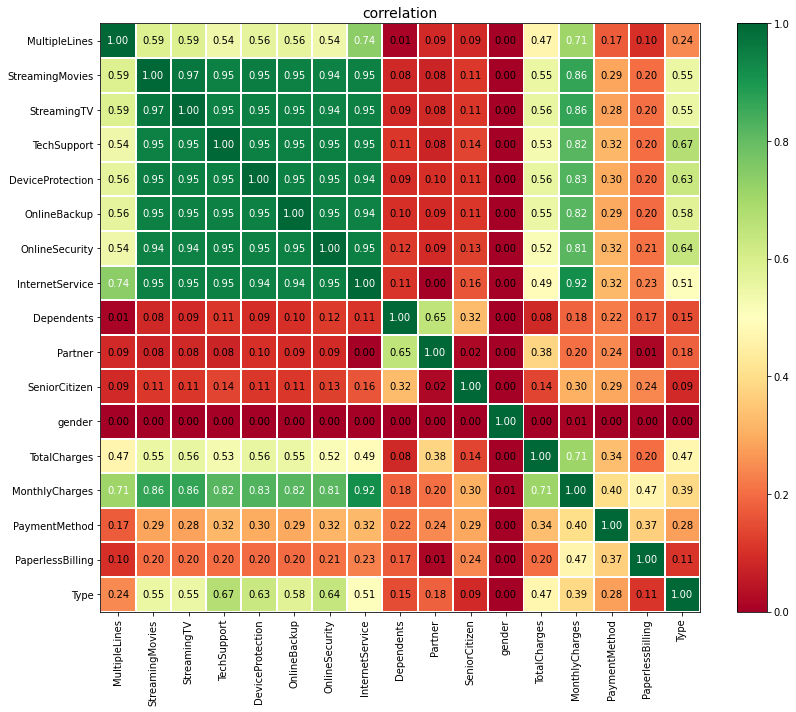

In [29]:
interval_cols = ['MonthlyCharges', 'TotalCharges']
df = full_data_set.drop(columns=['customerID', 'BeginDate', 'EndDate'])

cor_phik = df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
plot_correlation_matrix(cor_phik.values, 
                        x_labels=cor_phik.columns, 
                        y_labels=cor_phik.index,
                        vmin=0, vmax=1,
                        figsize=(12, 10))

- Матрица корреляции признаков показала что не все признаки коррелируют с признаком EndDate. Его к слову стоит перенести в числовой формат, со значение 1 - клиент ушел, 0 - клиент продливает контракт.
- Также можно сгенерировать такие признаки как длительность контракта: количество месяцев и дней.

In [30]:
full_data_set['EndDate_flag'] = full_data_set['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
display(full_data_set.head())
full_data_set['EndDate_flag'].unique()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_flag
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No phone service,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No phone service,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


array([0, 1])

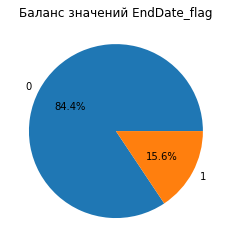

In [31]:
full_data_set['EndDate_flag'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Баланс значений EndDate_flag')
plt.ylabel('')
plt.show()

In [32]:
full_data_set['BeginDate'] = pd.to_datetime(full_data_set['BeginDate'])

download_date = pd.to_datetime("2020-02-01")

full_data_set['EndDate_clean'] = full_data_set['EndDate'].replace("No", download_date)
full_data_set['EndDate_clean'] = pd.to_datetime(full_data_set['EndDate_clean'])

full_data_set['contract_duration_days'] = (full_data_set['EndDate_clean'] - full_data_set['BeginDate']).dt.days

full_data_set['contract_duration_months'] = (full_data_set['contract_duration_days'] / 30).round()

In [33]:
display(full_data_set.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_flag,EndDate_clean,contract_duration_days,contract_duration_months
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,Yes,No,No,No,No,No phone service,0,2020-02-01,31,1.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,Yes,No,No,No,No,0,2020-02-01,1036,35.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,No,No,No,No,No,0,2020-02-01,123,4.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,Yes,Yes,No,No,No phone service,0,2020-02-01,1371,46.0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,0,2020-02-01,153,5.0


<Figure size 864x720 with 0 Axes>

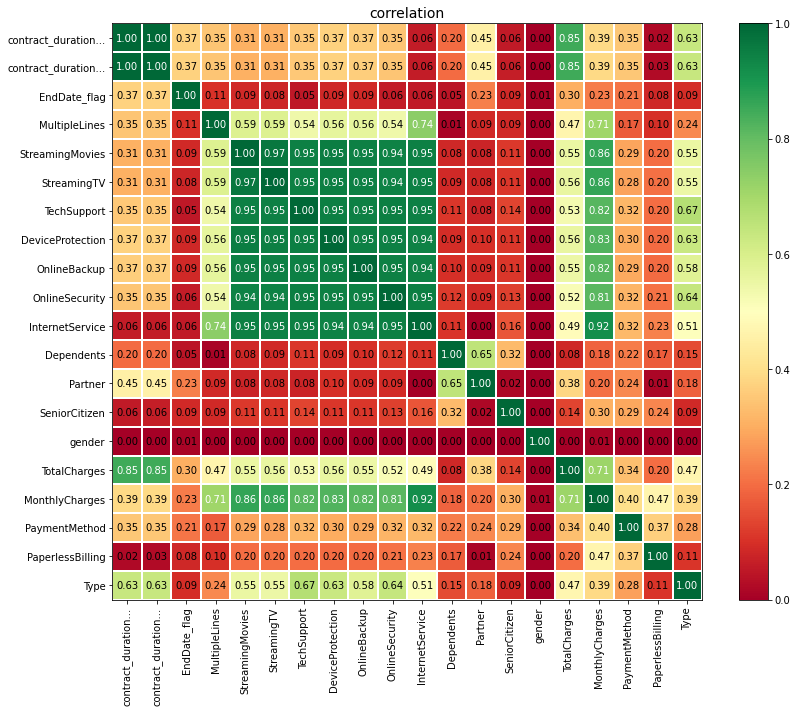

In [34]:
excluded_cols = ['BeginDate', 'EndDate', 'EndDate_clean', 'customerID']

data_for_phik = full_data_set.drop(columns=excluded_cols, errors='ignore')

interval_cols = [
    'MonthlyCharges',
    'TotalCharges',
    'contract_duration_days',
    'contract_duration_months'
]

cor_phik = data_for_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
plot_correlation_matrix(
    cor_phik.values,
    x_labels=cor_phik.columns,
    y_labels=cor_phik.index,
    vmin=0, vmax=1,
    figsize=(12, 10)
)

- Перевод целевого признака в формат 0/1 (бинарный) дала возможность повысить точность в вычислении корреляции признаков.
- Былы проведена операция по генерации новых признаков, которые явно коррелируют с целевый признаком EndDate_flag.
- Признаки со слабой зависимостью следует удалить для уменьшения шума. 

In [35]:
cols_to_drop = ['BeginDate', 'EndDate', 'EndDate_clean', 'customerID', 'gender', 'SeniorCitizen', 'contract_duration_months']
full_data_set = full_data_set.drop(columns=cols_to_drop)

display(full_data_set.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_flag,contract_duration_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,Yes,No,DSL,No,Yes,No,No,No,No,No phone service,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone service,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


<Figure size 864x720 with 0 Axes>

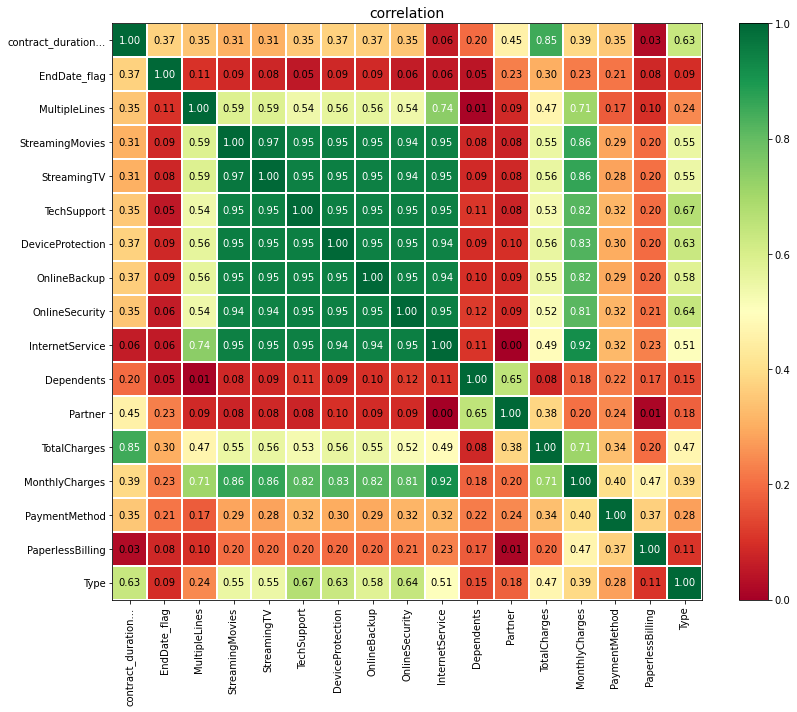

In [36]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'contract_duration_days']

cor_phik = full_data_set.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
plot_correlation_matrix(cor_phik.values, 
                        x_labels=cor_phik.columns, 
                        y_labels=cor_phik.index,
                        vmin=0, vmax=1,
                        figsize=(12, 10))

In [37]:
display(full_data_set.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_flag,contract_duration_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,Yes,No,DSL,No,Yes,No,No,No,No,No phone service,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone service,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


<b>Вывод</b>
- Была проведена операция по генерации новых признаков, таких как длительность контракта в днях и месяцах.
- Удалены признаки создающие шум или не несущие информацию: ID, дата начала контракта, дата конца контракта, пол, статус пенсионера.
- Также выявлено что некоторые признаки сильно коррелируют между собой, стоит это учесть при МО.

# Исследовательский анализ данных объединенного файла.

In [38]:
df = full_data_set.copy()
target = "EndDate_flag"
numeric_cols = [ 'MonthlyCharges', 'TotalCharges', 'contract_duration_days' ]


 Признак: MonthlyCharges


,count,mean,std,min,25%,50%,75%,max
EndDate_flag,,,,,,,,
0,5942.0,62.76,29.84,18.25,30.06,69.2,87.24,118.60
1,1101.0,75.55,29.12,18.40,56.15,84.2,99.50,118.75


Mann–Whitney p-value = 0.0000 → значимо


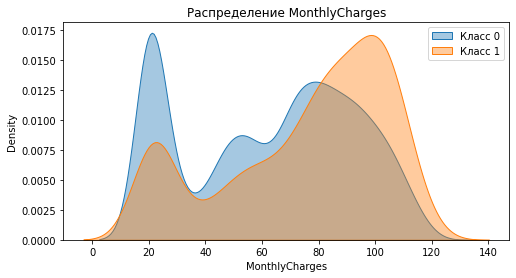

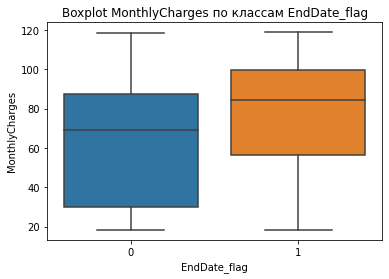


 Признак: TotalCharges


,count,mean,std,min,25%,50%,75%,max
EndDate_flag,,,,,,,,
0,5942.0,2067.87,2193.90,0.00,374.35,1192.80,3173.84,9221.38
1,1101.0,2371.38,1581.86,77.84,1048.05,2139.03,3404.91,7649.76


Mann–Whitney p-value = 0.0000 → значимо


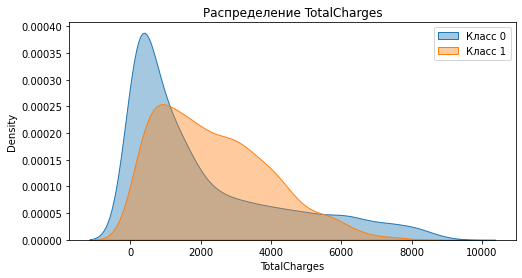

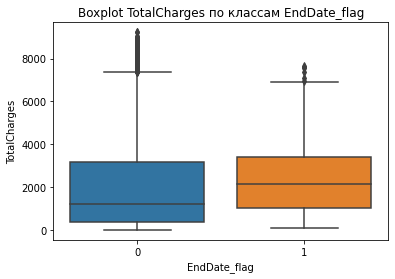


 Признак: contract_duration_days


,count,mean,std,min,25%,50%,75%,max
EndDate_flag,,,,,,,,
0,5942.0,893.68,716.96,0.0,245.0,702.0,1523.0,2314.0
1,1101.0,924.86,458.77,28.0,577.0,915.0,1249.0,2129.0


Mann–Whitney p-value = 0.0000 → значимо


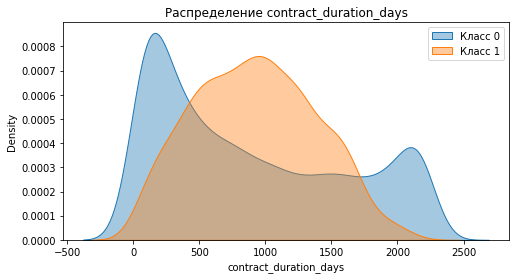

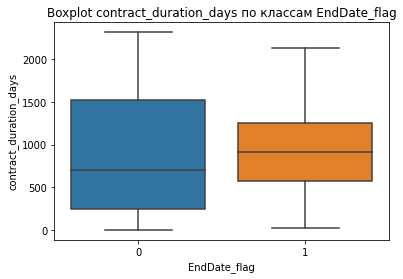

In [39]:
for col in numeric_cols:
    print(f"\n Признак: {col}")

    display(df.groupby(target)[col].describe().round(2))


    u_stat, p = mannwhitneyu(
        df[df[target]==0][col], 
        df[df[target]==1][col],
        alternative="two-sided"
    )
    print(f"Mann–Whitney p-value = {p:.4f} → {'значимо' if p<0.05 else 'не значимо'}")

    plt.figure(figsize=(8,4))
    sns.kdeplot(df[df[target]==0][col], label="Класс 0", fill=True, alpha=0.4)
    sns.kdeplot(df[df[target]==1][col], label="Класс 1", fill=True, alpha=0.4)
    plt.title(f"Распределение {col}")
    plt.legend()
    plt.show()

    sns.boxplot(x=target, y=col, data=df)
    plt.title(f"Boxplot {col} по классам EndDate_flag")
    plt.show()

<b>Предварительный вывод</b>

Визуализация числовых признаков и целевого признака показала что:
- Чем выше ежемесячный платеж (MonthlyCharges) тем больше вероятность что клиент разорвет контракт, возможно стоит пересмотреть политику компании по предоставлению дополнительных платных услуг, или ввести тариф где абонентская плата не будет превышать 60 долларов, потому что вероятность потерять клиента возрастает после этого значения.
- Клиенты которые решили уйти, принесли компании значительно больше средств за все время - 2139 против 1192 тех кто продолжает быть клиентом.
- У оранжевой кривой пик находится примерно в диапазоне 700–1200 дней. То есть много тех, кто ушёл, имели длительные контракты. Это может указывать на: 

<b> 
    
1)ухудшение условий после длительного использования; 
    
2)повышение тарифов со временем; 
    
3)накопление неудовлетворённости. </b>


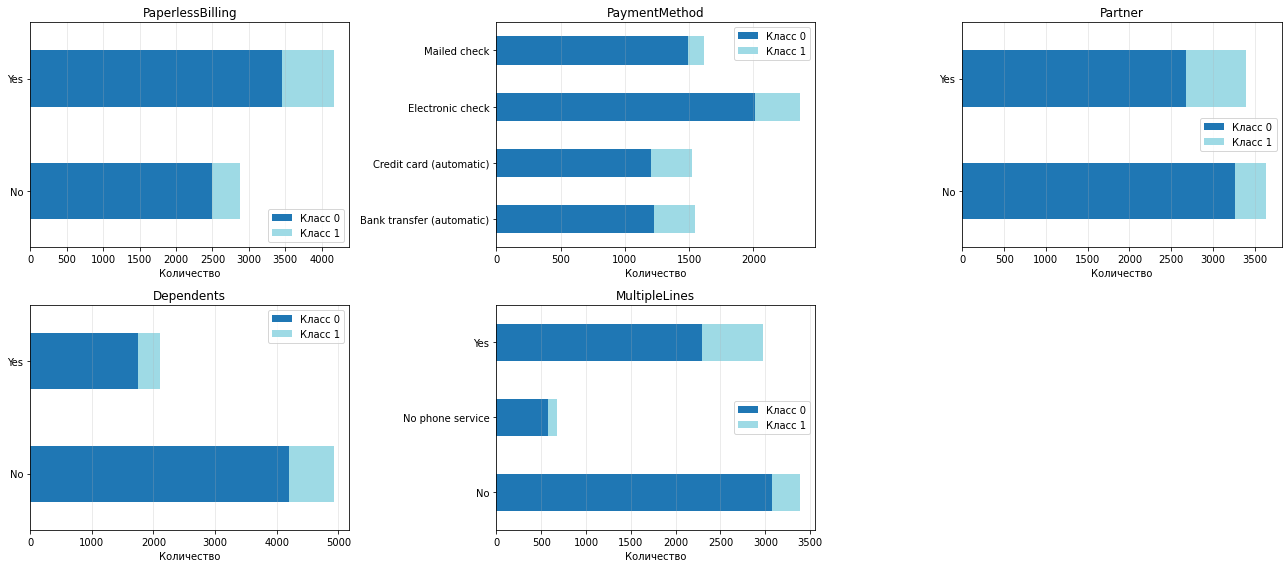

In [40]:
def plot_cat_features_grid(df, features, target='EndDate_flag', ncols=3):
    nrows = (len(features) + ncols - 1) // ncols 

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))
    axes = axes.flatten()

    for ax, feature in zip(axes, features):
        counts = df.groupby([feature, target]).size().unstack(fill_value=0)

        counts.plot(
            kind='barh',
            stacked=True,
            ax=ax,
            colormap='tab20'
        )

        ax.set_title(f'{feature}')
        ax.set_xlabel('Количество')
        ax.set_ylabel('')
        ax.grid(axis='x', alpha=0.3)
        ax.legend(['Класс 0', 'Класс 1'])

    for ax in axes[len(features):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


cat_cols = [ 'PaperlessBilling', 'PaymentMethod', 'Partner', 'Dependents', 'MultipleLines'] 

plot_cat_features_grid(full_data_set, cat_cols, target='EndDate_flag')

- Заметно что чем больше опций покупает клиент тем выше вероятность того что клиент современем откажется от услуг компании. ('StreamingTV', 'StreamingMovies', 'MultipleLines') 
- Наличие партнера тоже является признаком увеличивающим шансы что клиент со временем разорвет контракт.

<b>Вывод</b>

Анализ показал наличие зависимостей от таких признаков как:
1) ежемесячная оплата, чем выше тем больше вероятность того что клиент уйдет

2) наличие дополнительных опций которые клиент решил купить, ('StreamingTV', 'StreamingMovies', 'MultipleLines', 'Fiber optic')

# Обучение моделей машинного обучения

In [41]:
display(full_data_set.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_flag,contract_duration_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,Yes,No,DSL,No,Yes,No,No,No,No,No phone service,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone service,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [42]:
RANDOM_STATE = 11225
TEST_SIZE = 0.25

X = full_data_set.drop(['EndDate_flag'], axis=1)
y = full_data_set['EndDate_flag']


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [43]:
ohe_columns = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines']
ord_columns = ['PaperlessBilling', 'Partner', 'Dependents']
num_columns = ['contract_duration_days', 'TotalCharges', 'MonthlyCharges']

In [44]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=[['No', 'Yes']] * len(ord_columns)
    ))
])

In [45]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_columns),
    ('cat', categorical_transformer, ohe_columns),
    ('bin', binary_transformer, ord_columns)
    ])

gb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('pca', PCA()), # метод главных компонент для модели чувствительной к мультикорреляции
    ('clf', LogisticRegression(max_iter=5000))
])

In [46]:
X_prep = preprocessor.fit_transform(X_train)
print(X_prep.shape)

(5282, 19)


In [47]:
gb_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5]
}

rf_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5]
}

lr_param_grid = {
    'pca__n_components': [5, 10, 15, 19],   # максимум = 19
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['saga']
}

In [48]:
cv = 5
scoring = 'roc_auc'

gs_gb = GridSearchCV(gb_pipeline, gb_param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
gs_rf = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
gs_lr = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)

print("Fitting GradientBoosting GridSearch...")
gs_gb.fit(X_train, y_train)
print("Fitting RandomForest GridSearch...")
gs_rf.fit(X_train, y_train)
print("Fitting LogisticRegression GridSearch...")
gs_lr.fit(X_train, y_train)

best_gb = gs_gb.best_estimator_
best_rf = gs_rf.best_estimator_
best_lr = gs_lr.best_estimator_

print("\nBest params GB:", gs_gb.best_params_)
print("Best CV AUC GB:", gs_gb.best_score_)
print("\nBest params RF:", gs_rf.best_params_)
print("Best CV AUC RF:", gs_rf.best_score_)
print("\nBest params LR:", gs_lr.best_params_)
print("Best CV AUC LR:", gs_lr.best_score_)

Fitting GradientBoosting GridSearch...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting RandomForest GridSearch...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting LogisticRegression GridSearch...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best params GB: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 300}
Best CV AUC GB: 0.8915247167622671

Best params RF: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Best CV AUC RF: 0.8256414789855796

Best params LR: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'pca__n_components': 15}
Best CV AUC LR: 0.7598326783125386


In [49]:
def evaluate_gb_model(pipe, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== GradientBoosting Test Evaluation ===")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'GradientBoosting (AUC={auc:.3f})', color='blue')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve — Gradient Boosting')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return auc, acc

In [50]:
def show_feature_importances(pipe, top_n=30, title="Feature importance"):
    feature_names = get_feature_names_from_trained_pipeline(pipe)
    clf = pipe.named_steps['clf']

    print(f"\n{title}\n" + "-" * len(title))

    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        idx = np.argsort(importances)[::-1][:top_n]
        for i in idx:
            print(f"{feature_names[i]:50s} : {importances[i]:.5f}")

    elif hasattr(clf, 'coef_'):
        coefs = clf.coef_.ravel()
        idx = np.argsort(np.abs(coefs))[::-1][:top_n]
        for i in idx:
            print(f"{feature_names[i]:50s} : coef={coefs[i]:.5f} | abs={abs(coefs[i]):.5f}")

    else:
        print("Модель не поддерживает feature importance.")

def get_feature_names_from_trained_pipeline(pipeline):
    preprocessor = pipeline.named_steps['pre']
    feature_names = []

    for name, trans, cols in preprocessor.transformers_:
        
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols) 
    return feature_names


=== GradientBoosting Test Evaluation ===
AUC-ROC: 0.9127
Accuracy: 0.9063
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1486
           1       0.87      0.47      0.61       275

    accuracy                           0.91      1761
   macro avg       0.89      0.73      0.78      1761
weighted avg       0.90      0.91      0.89      1761



/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


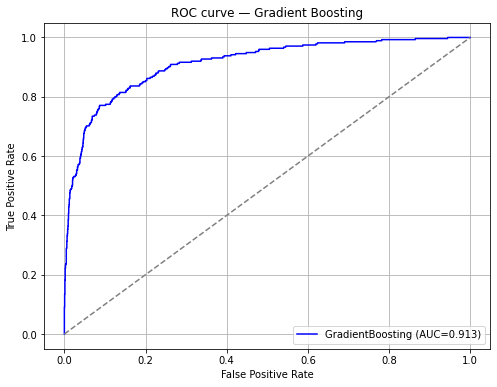

In [51]:
feature_names = get_feature_names_from_trained_pipeline(best_gb)

auc_test, acc_test = evaluate_gb_model(best_gb, X_test, y_test)

In [52]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)
y_pred_best = best_gb.predict(X_test)

y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]
y_proba_best = best_gb.predict_proba(X_test)[:, 1]

dummy_auc = roc_auc_score(y_test, y_proba_dummy)
best_auc = roc_auc_score(y_test, y_proba_best)

print(f"Dummy ROC-AUC: {dummy_auc:.4f}")
print(f"Best model ROC-AUC: {best_auc:.4f}")

Dummy ROC-AUC: 0.5000
Best model ROC-AUC: 0.9127


В сравнении с DummyClassifier которая просто угадывает на данных (Dummy ROC-AUC: 0.5), наша модель правлиьно предсказала узод клиентв в 91% случаев. Это значит что модель уловила взаимосвязь между признаками и не просто угадывает ответ.

In [53]:
show_feature_importances(best_gb, top_n=30)


Feature importance
------------------
contract_duration_days                             : 0.44644
MonthlyCharges                                     : 0.16604
TotalCharges                                       : 0.16320
Type_Month-to-month                                : 0.04837
Type_Two year                                      : 0.04034
Partner                                            : 0.02650
MultipleLines_No                                   : 0.02043
PaymentMethod_Mailed check                         : 0.01533
Dependents                                         : 0.01372
PaymentMethod_Credit card (automatic)              : 0.01312
Type_One year                                      : 0.01089
PaymentMethod_Bank transfer (automatic)            : 0.00951
MultipleLines_Yes                                  : 0.00649
MultipleLines_No phone service                     : 0.00614
PaymentMethod_Electronic check                     : 0.00530
PaperlessBilling                              

<b>Важность признаков</b>

- Анализ показал что самым важным признаком является длительность контракта, за ним идет ежемесячная оплата и общая сумма оплат.
- Добавочные сервисы и прочие признаки не играют столь значимой роли в предсказаниях.

<Figure size 432x360 with 0 Axes>

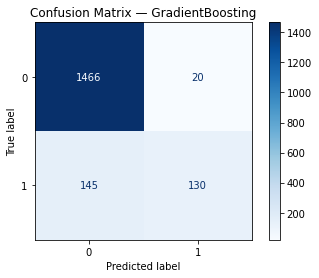

In [54]:
def plot_confusion_matrix(pipe, X_test, y_test, title="Confusion Matrix"):
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()
    
plot_confusion_matrix(best_gb, X_test, y_test, title="Confusion Matrix — GradientBoosting")


# Общий вывод и рекомендации.

- Лучшей моделью является GradientBoosting: с параметрами Best params GB: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 300}
- AUC-ROC: 0.9154
- Accuracy: 0.9074

<b>Цель исследования была достигнута, AUC-ROC выше > 0.85. </b> 

- Значение accuracy = 0.9074 означает, что модель корректно классифицирует около 91% наблюдений тестовой выборки. При этом качество модели превосходит константную модель DummyClassifier, что подтверждает её адекватность. Однако, с учётом сбалансированности классов, для более объективной оценки модели дополнительно были рассмотрены другие метрики (ROC-AUC, recall).

- Модель отлично справляется с выявлением случая: клиент не собирается уйти 1465 случая и модель корректно определила что клиент не уйдет. (f1-score 0.95: (точность 0.91/полнота 0.99))

- Модель практический не ошибается когда: "клиент не ушёл, а модель подумала, что ушёл" - всего 21 случая

- К сожалению модель все еще плохо выявляет случай где: клиент ушёл, а модель сказала "останется" - 142 пропущеных оттока. (f1-score 0.62: точность 0.86/полнота 0.48) модель ловит примерно 48% всех ушедших клиентов.

- Модель правильно нашла 133 клиента, которые действительно ушли.

<b>Рекомендации заказчику</b>

Из за малого количества данных о причинах ухода клиента, мы можем лишь косвенно догадываться о причинах, но все же некоторые выводы мы смогли сделать.

1) Клиенты которые вероятно уйдут имеют высокий ежемесячный платеж, медиана 84 долларов против 69.

2) Клиенты которые вероятно уйдут оставили компании больше денег в целом: 2139 долларов против 1192.

3) Клиенты которые вероятно уйдут чаще всего покупают доп опции вроде: стриминговых сервисов, оптического интернета, и телефонии.

- Возможно стратегия постоянного предоставления дополнительных услуг в итоге приводит к тому что клиент не рассчитывает свой бюджет на интернет услуги и в итоге переходит к конкурентам.

- Для увеличения точности выявления клиентов которые намериваются уйти стоит разработать систему обратной связи, когда клиент получает рассылку с просьбой заполнить форму где указывает причины разрыва контракта. 